In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
data_dir = 'brain-tumor-detection'
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3000


In [4]:
batch_size = 32
img_height = 180
img_width = 180


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.7918 - loss: 0.4554 - val_accuracy: 0.8600 - val_loss: 0.3217
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.8246 - loss: 0.3854 - val_accuracy: 0.8717 - val_loss: 0.2752
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.8348 - loss: 0.3833 - val_accuracy: 0.7967 - val_loss: 0.5308
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.8536 - loss: 0.3266 - val_accuracy: 0.9117 - val_loss: 0.2089
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.8784 - loss: 0.2903 - val_accuracy: 0.8833 - val_loss: 0.2873
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.8967 - loss: 0.2540 - val_accuracy: 0.9167 - val_loss: 0.2345
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.9074 - loss: 0.2386 - val_accuracy: 0.8850 - val_loss: 0.3312
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.9180 - loss: 0.2113 - val_accu

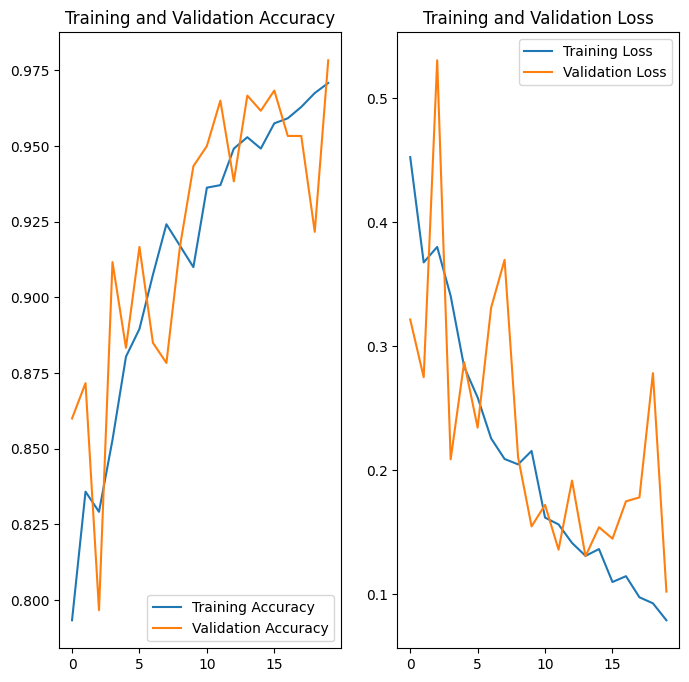

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import time
t = time.time()

export_path = "saved_models/yes-no.keras"
model.save(export_path)

export_path

'saved_models/yes-no.keras'

In [20]:
import random
reloaded = tf.keras.models.load_model(export_path)
#test on a random image
val_loss, val_accuracy = reloaded.evaluate(val_ds)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9838 - loss: 0.0710
Validation Loss: 0.10223386436700821, Validation Accuracy: 0.9783333539962769


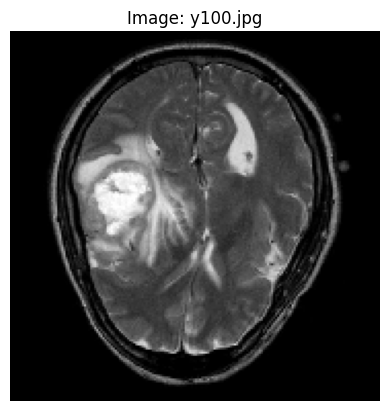

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image: y100.jpg, Predicted Class: yes


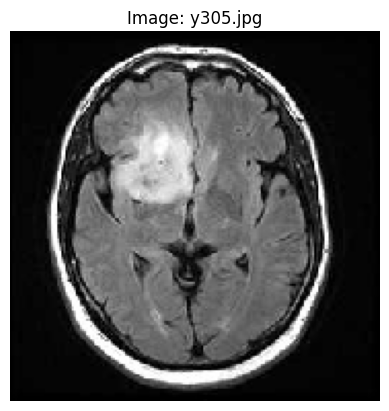

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Image: y305.jpg, Predicted Class: yes


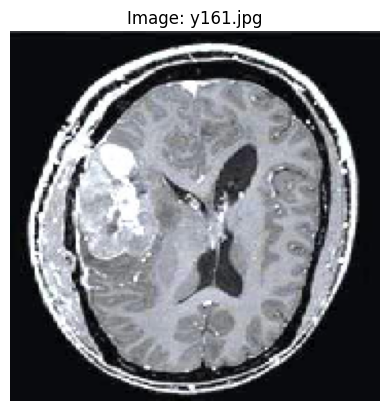

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: y161.jpg, Predicted Class: yes


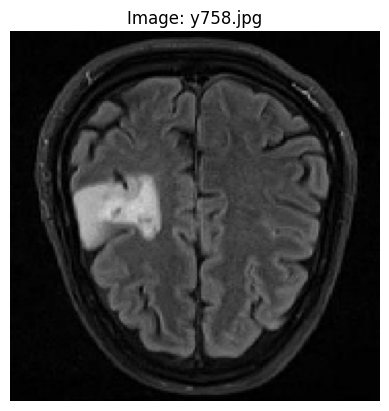

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: y758.jpg, Predicted Class: yes


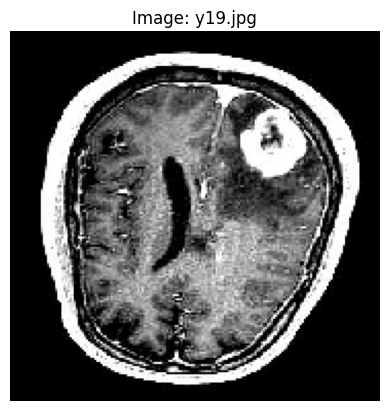

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: y19.jpg, Predicted Class: yes


In [21]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Directory containing the images
yes_dir = os.path.join(data_dir, "yes")

# Get a list of all image file paths in the "yes" directory
image_paths = list(pathlib.Path(yes_dir).glob("*.jpg"))

# Select a random subset of images
random_images = random.sample(image_paths, 5)  # Change 5 to the desired number of random images

# Predict the class for each random image
for image_path in random_images:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}")

y_true shape: (600,)  | unique: [0 1]
y_pred shape: (600,)  | unique: [0 1]


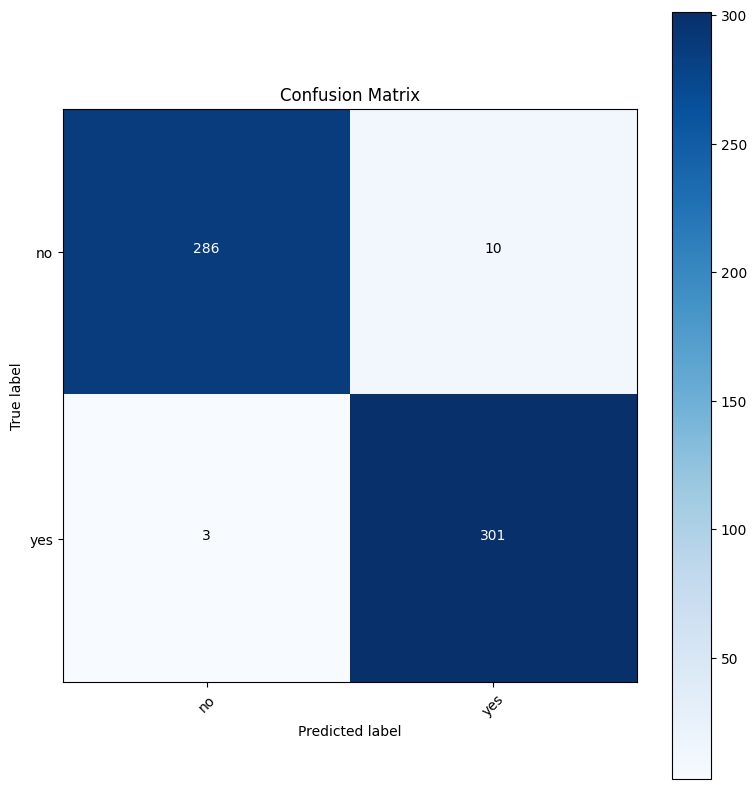

True Positives (TP): 301
False Positives (FP): 10
True Negatives (TN): 286
False Negatives (FN): 3

Classification Report:

              precision    recall  f1-score   support

         yes       0.99      0.97      0.98       296
          no       0.97      0.99      0.98       304

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



In [40]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_true = []
y_pred_logits = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())                          
    logits = model.predict(images, verbose=0)
    y_pred_logits.extend(logits)

y_true = np.array(y_true).astype("int32").squeeze()
y_pred_logits = np.array(y_pred_logits)

y_pred_probs = tf.nn.softmax(y_pred_logits, axis=1).numpy()

y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape, " | unique:", np.unique(y_true))
print("y_pred shape:", y_pred.shape, " | unique:", np.unique(y_pred))

cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix from white to dark blue
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#add values to the confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.title('Confusion Matrix')
plt.show()
tn, fp, fn, tp = cm.ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['yes', 'no']))


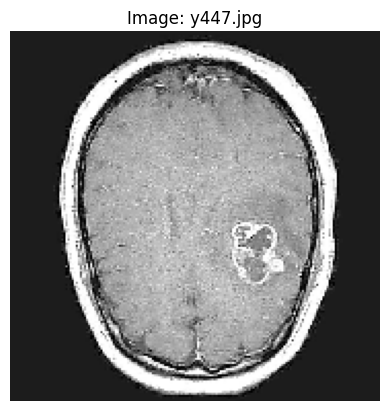

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: y447.jpg, Predicted Class: yes


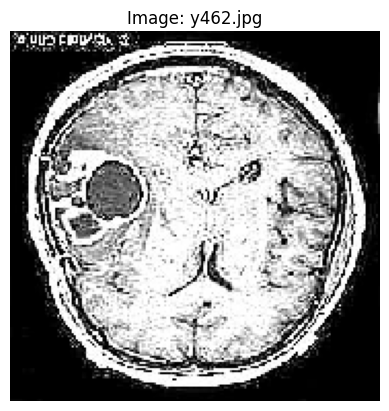

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: y462.jpg, Predicted Class: yes


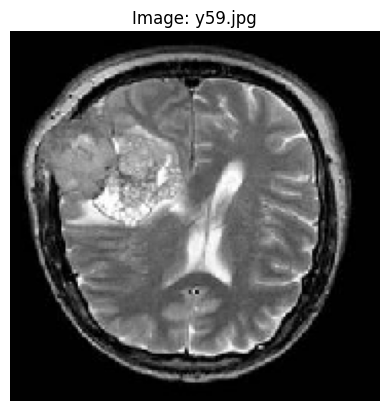

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: y59.jpg, Predicted Class: yes


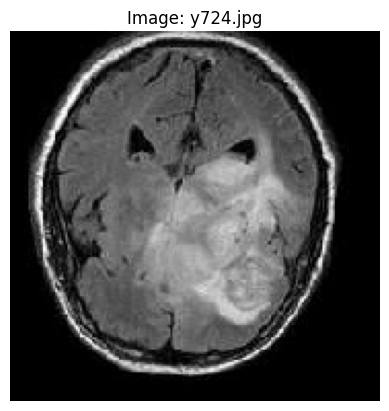

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: y724.jpg, Predicted Class: yes


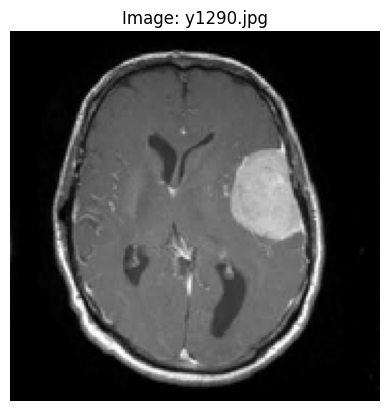

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: y1290.jpg, Predicted Class: yes






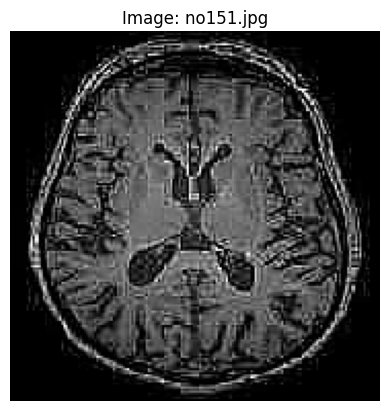

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: no151.jpg, Predicted Class: no, Confidence: 3.384098529815674


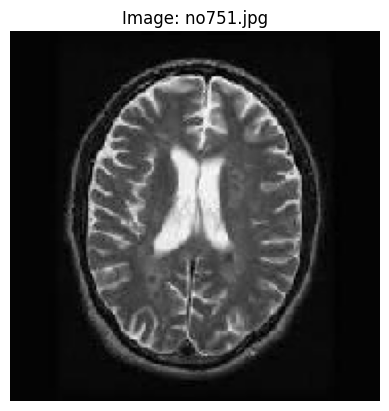

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: no751.jpg, Predicted Class: no, Confidence: 4.149287223815918


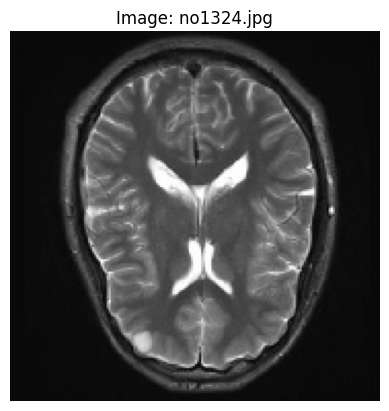

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: no1324.jpg, Predicted Class: no, Confidence: 6.494389057159424


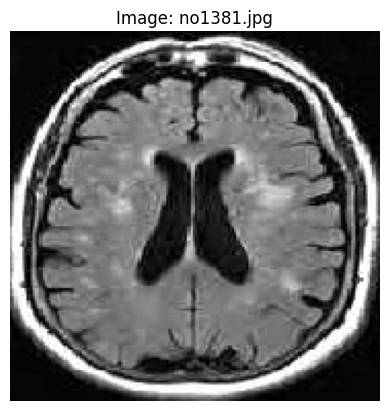

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: no1381.jpg, Predicted Class: no, Confidence: 6.1682515144348145


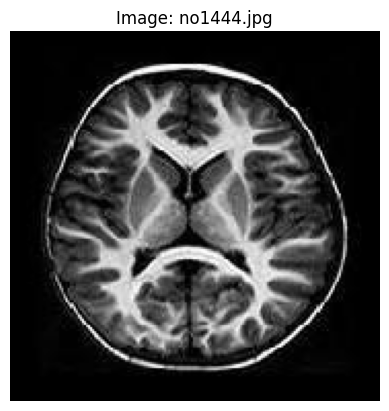

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: no1444.jpg, Predicted Class: no, Confidence: 1.638575792312622


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Directory containing the images
y_dir = os.path.join(data_dir, "yes/")
n_dir = os.path.join(data_dir, "no/")

# Get a list of all image file paths in the "yes" directory
image_paths_y = list(pathlib.Path(y_dir).glob("*.jpg"))
image_paths_n = list(pathlib.Path(n_dir).glob("*.jpg"))


test_num= 5    # Change to the desired number of random images

# Select a random subset of images
random_images_y = random.sample(image_paths_y, test_num)  
random_images_n = random.sample(image_paths_n, test_num) 

# Predict the class for each random image (BENIGN)
for image_path in random_images_y:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}")

print("\n\n\n")
# Predict the class for each random image (MALIGNANT)
for image_path in random_images_n:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}")


Micro-average ROC-AUC (OvR):    0.9929
Macro-average ROC-AUC (OvR):    0.9936
Weighted-average ROC-AUC (OvR): 0.9936
Per-class ROC-AUC (OvR):        [0.99356552 0.99356552]


/var/folders/k5/j3w6ff0s2t9_fqstgwms43n80000gn/T/ipykernel_3404/2382866817.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10').colors  # or define your own list


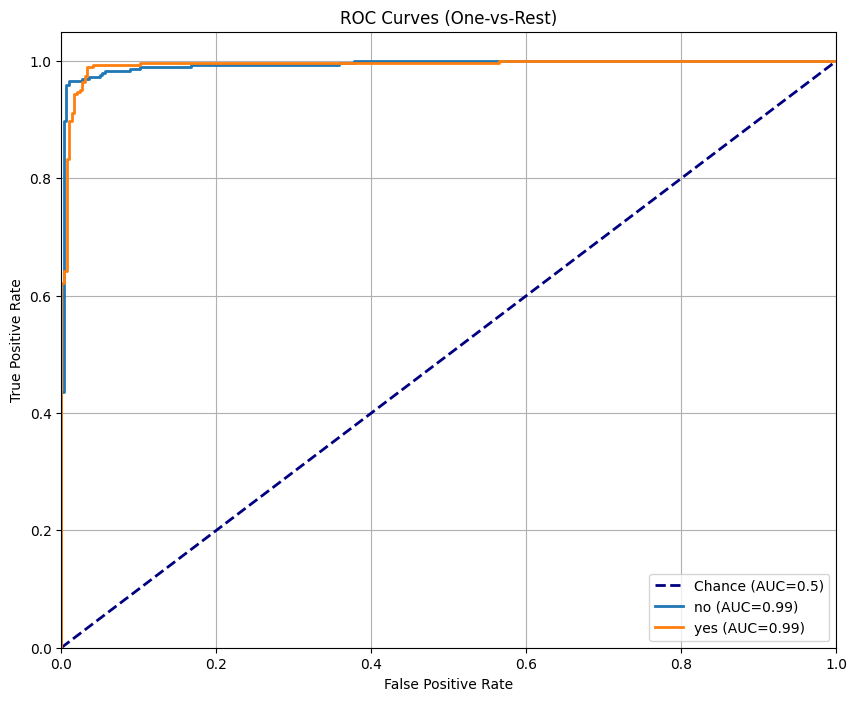

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming you've already computed:
#   y_true      → shape (n_samples,)
#   y_pred_probs→ shape (n_samples, num_classes)
# If not, compute them as in your confusion‐matrix cell.

# 1) One‐hot encode the true labels
num_classes = y_pred_probs.shape[1]
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes)

# 2) Compute OvR ROC‐AUC scores
try:
    roc_auc_micro_ovr    = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='micro')
    roc_auc_macro_ovr    = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='macro')
    roc_auc_weighted_ovr = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='weighted')
    per_class_auc_ovr    = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average=None)

    print(f"Micro-average ROC-AUC (OvR):    {roc_auc_micro_ovr:.4f}")
    print(f"Macro-average ROC-AUC (OvR):    {roc_auc_macro_ovr:.4f}")
    print(f"Weighted-average ROC-AUC (OvR): {roc_auc_weighted_ovr:.4f}")
    print(f"Per-class ROC-AUC (OvR):        {per_class_auc_ovr}")
except ValueError as e:
    print(f"\nError calculating ROC-AUC: {e}")
    print("Make sure your test set contains all classes.")

# 3) Plot per-class ROC curves
colors = plt.cm.get_cmap('tab10').colors  # or define your own list

plt.figure(figsize=(10, 8))
lw = 2
# Chance line
plt.plot([0,1], [0,1], linestyle='--', color='navy', lw=lw, label='Chance (AUC=0.5)')

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    label = class_names[i] if i < len(class_names) else f"Class {i}"
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=lw,
             label=f"{label} (AUC={per_class_auc_ovr[i]:.2f})")

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()